# NEURON SIMULATION

In this project we are going to simulate a neuron in two different ways

### Simple Integrate And Fire Model

This model takes an input current that gets translated into a voltage increase. When a certain voltage level is given($V_{th}$), the neuron spikes up to a maximum voltage and then resets to a $V_{rest}$ voltage.

The the model follows:
$$
\tau_m \frac{dV}{dt} = V_{rest} -V + R·I
$$
Where $R$ and $I$ are the membrane resistance and the inpur current

We can also simulate a spike adaptation adaptation mechanism that reduces firing rate after prolonged stimulation with a constant input given by:
$$
\tau_m \frac{dV}{dt} = V_{rest} - g_{sra}(V-V_{rest}) - V + R·I
$$
$$
\tau_{gsra} \frac{dg_{sra}}{dt}
$$

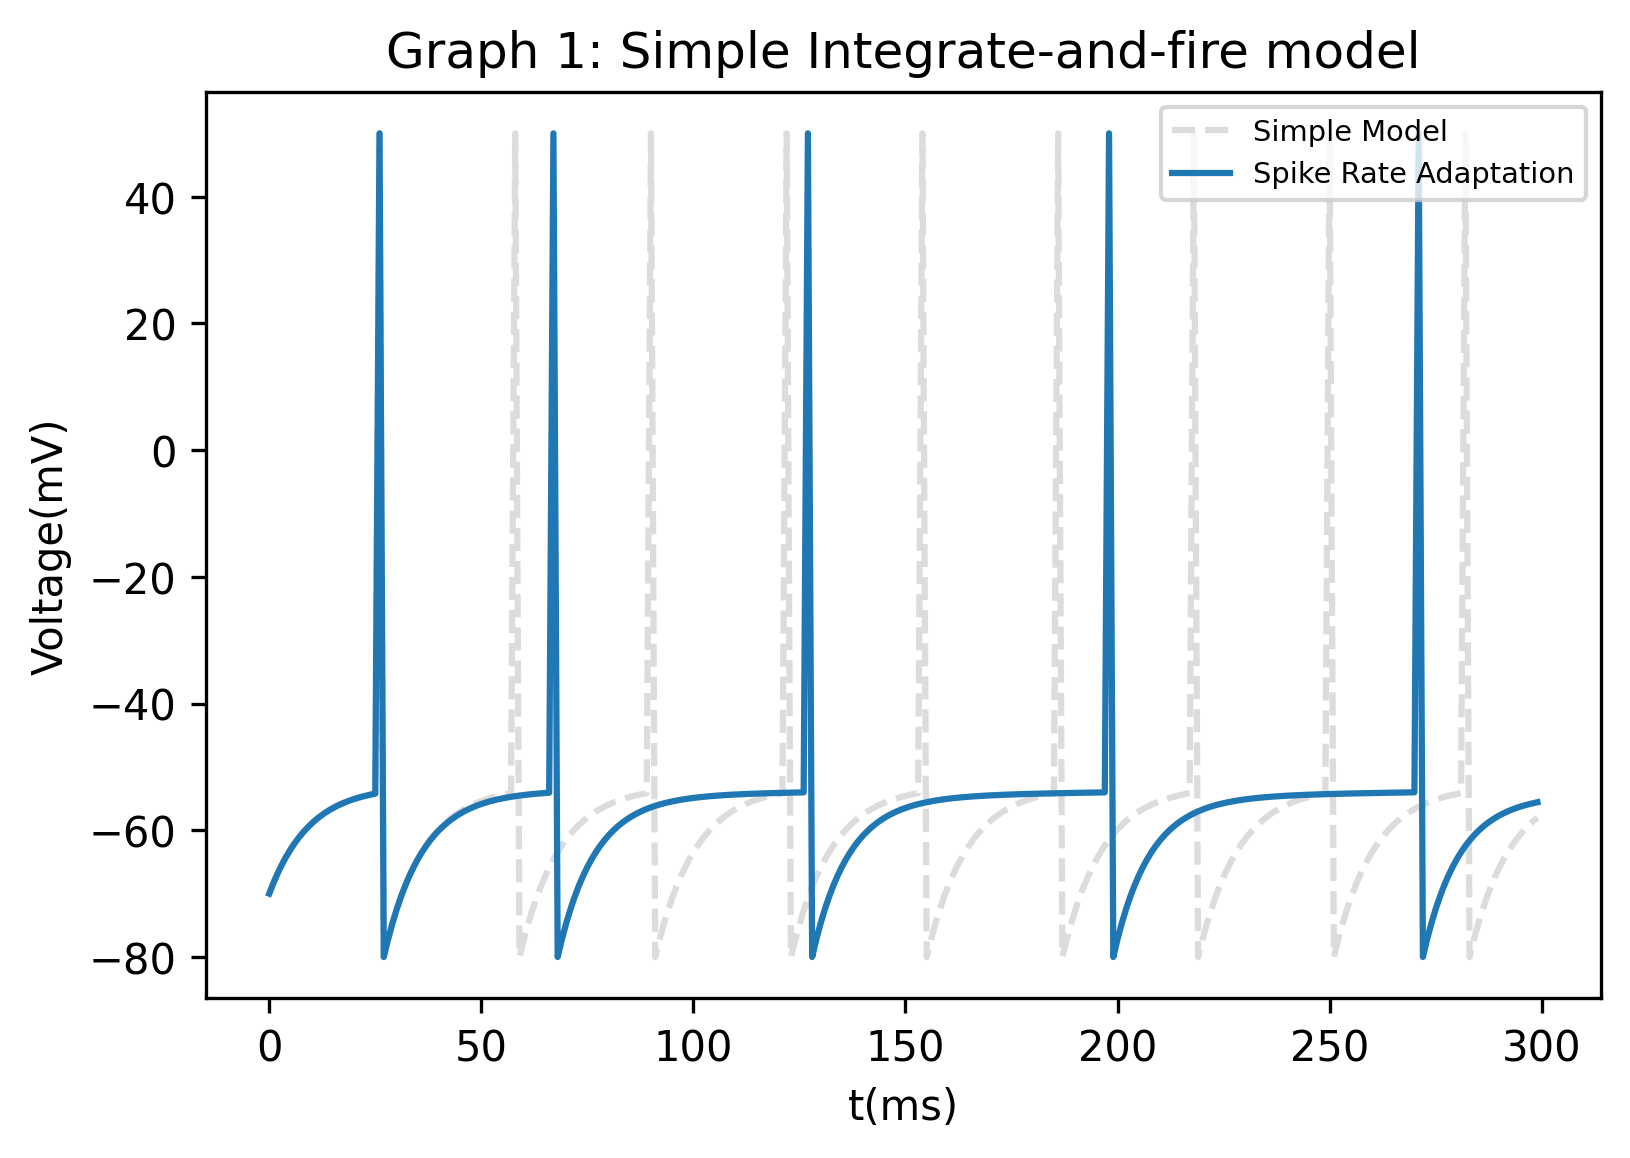

In [3]:
%matplotlib inline
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import scipy.integrate
import scipy
plt.rcParams['figure.dpi']= 300

# Parameter definitions
V_rest = -70 # mV
V_reset= -80 # mV
R_m    =  10 # Mohm
tau_m  =  10 # ms
V_th   = -54 # mV
I      =  1.7 # nA
T      = 300

spike_times = []
V = np.zeros(T)
V[0] = V_rest

# Euler method
def eulerMeth(option, V_rest1 = V_rest, V_reset1 = V_reset, R_m1 = R_m, tau_m1 = tau_m, V_th1 = V_th, I1 = I, T1 = T):
    tau_gsra = 100
    g_sra = 0
    firrate = []
    for i in range(1,T1):
        dV1 = V_rest1 - V[i-1] - g_sra*(V[i-1] - V_rest1) + R_m1*I1
        if(option == 3):
            g_sra = g_sra - (g_sra/tau_gsra)
        V[i] = V[i-1] + dV1/tau_m1

        if V[i] > V_th1:
            V[i-1] = 50
            V[i] = V_reset1
            if(option == 3):
                g_sra += 0.06
            firrate.append(i)

    if(option == 0 or option == 3):
            return V
    if(option == 1):
        if(len(firrate)>2):
            return 1000/(firrate[1]-firrate[0])
        else:
            return 0


fig, ax = plt.subplots(1, 1)
ax.plot(eulerMeth(option = 0), color='#DCDCDC', linestyle='dashed',  label='Simple Model')
ax.plot(eulerMeth(option = 3), label='Spike Rate Adaptation')
ax.set_title('Graph 1: Simple Integrate-and-fire model')
ax.set_xlabel('t(ms)')
ax.set_ylabel('Voltage(mV)')
ax.legend(fontsize = 'x-small', loc='upper right');

We can see how as we expected, the firing rate decreases as the spikes take place

Now we can compute the relation between the firing rate and the current. Given a higher current input we should expect the firing rate to increase

Text(0, 0.5, 'Firing Rate(Hz)')

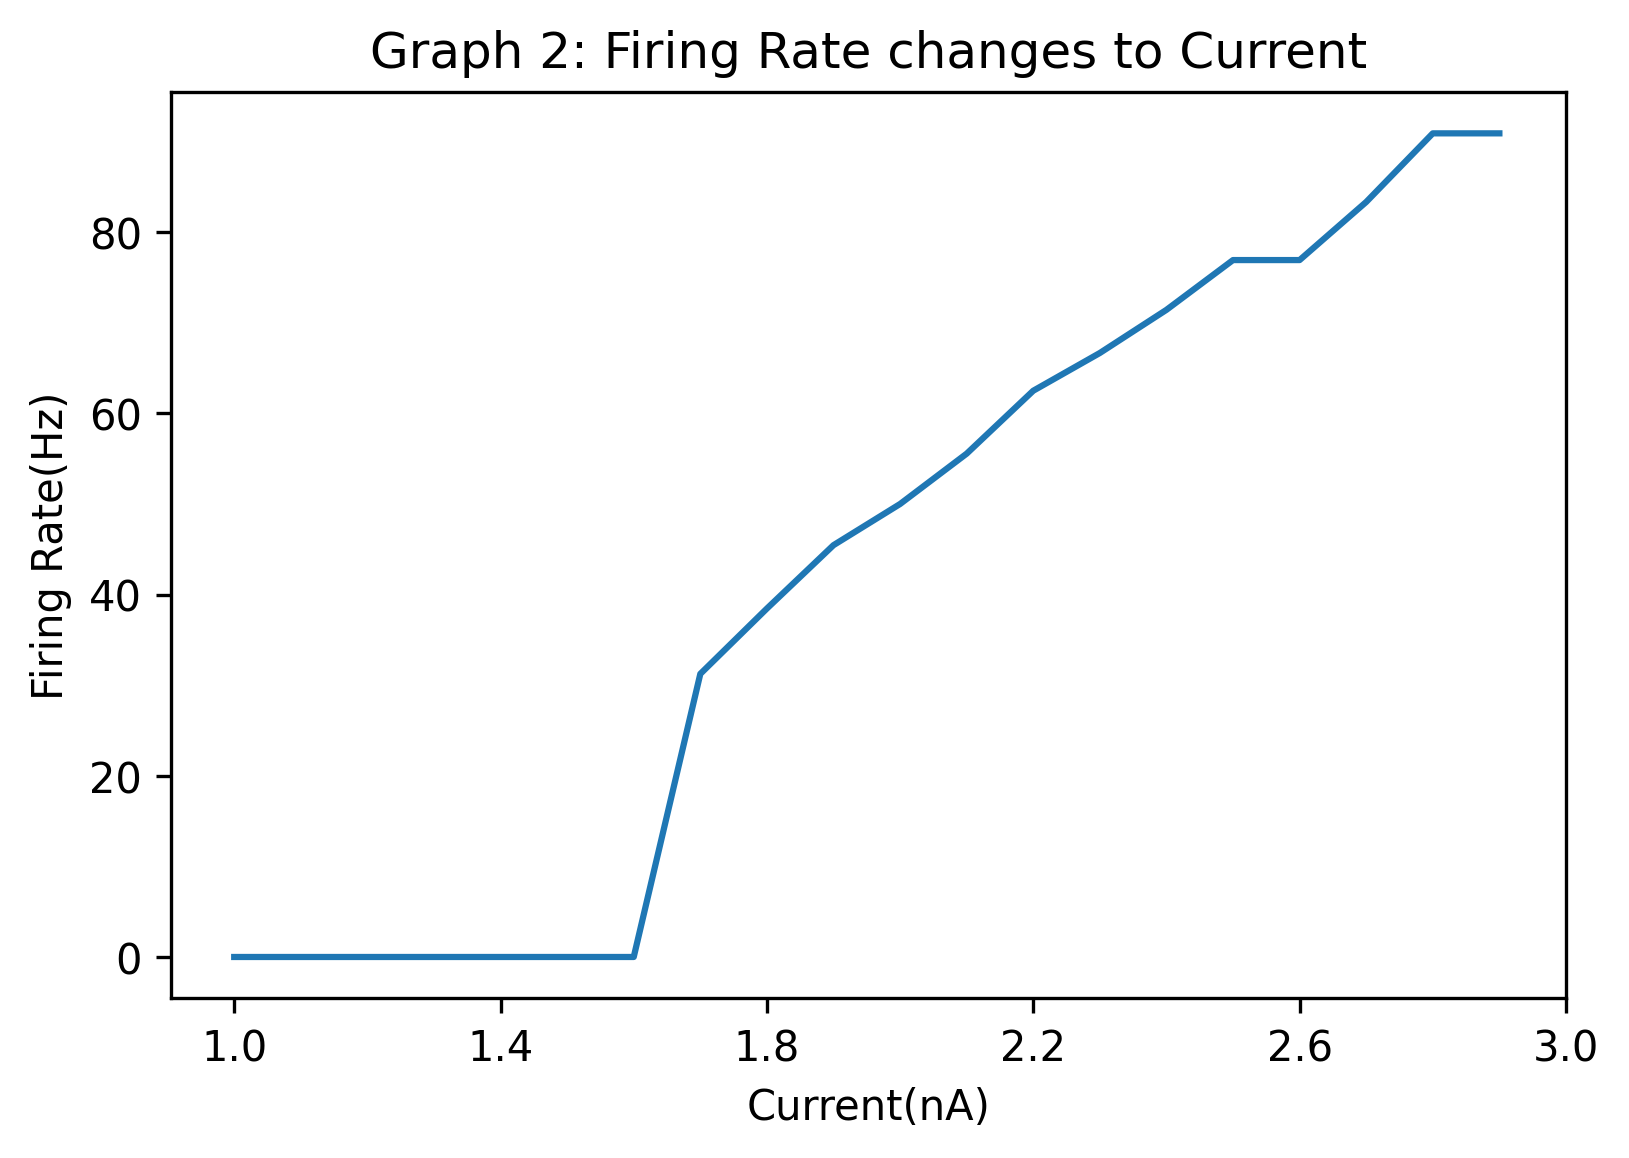

In [4]:
fig, ax = plt.subplots(1, 1)

I_var = np.arange(1, 3, 0.1)
firing_rate = []
for i in I_var:
    firing_rate.append(eulerMeth(option = 1, I1 = i))
    
ax.plot(firing_rate)
ax.set_xticks(np.arange(24, step = 4), np.arange(10, 34, 4)/10)
ax.set_title('Graph 2: Firing Rate changes to Current')
ax.set_xlabel('Current(nA)')
ax.set_ylabel('Firing Rate(Hz)')

### Fitzhugh-Nagumo

We are now going to compute a phase-plane based model, which takes advantage of the nature of phase planes and has its own threshold voltage, maximum voltage and reset voltage.

We first define the time and voltage dependent phase plane

In [5]:

finalTime = 300
sc = {"a":-.3, "b":1.4, "tau":20, "I":0.23}

def PhasePlane(x, t, a, b, tau, I):
    return np.array([x[0] - x[0]**3 - x[1] + I, 
                     (x[0] - a - b * x[1])/tau])

We also need a function that calculates the changes the voltage changes using the phase plane:

In [6]:

def get_displacement(param, dmax=0.5,time_span=np.linspace(0,finalTime, 1000), number=20):
    # We start from the resting point...
    ic = scipy.integrate.odeint(partial(PhasePlane, **param),
                                                      y0=[0,0],
                                                      t= np.linspace(0,999, 1000))[-1]
    # and do some displacement of the potential.  
    return (scipy.integrate.odeint(partial(PhasePlane, **param),
                                                    y0=ic+np.array([0,0]),
                                                    t=time_span))

traject = get_displacement(sc, number=1, time_span=np.linspace(0, finalTime, num=1500), dmax=0.5)


And now we can plot the spikes with the voltage and with the auxiliar-corrector vairable u

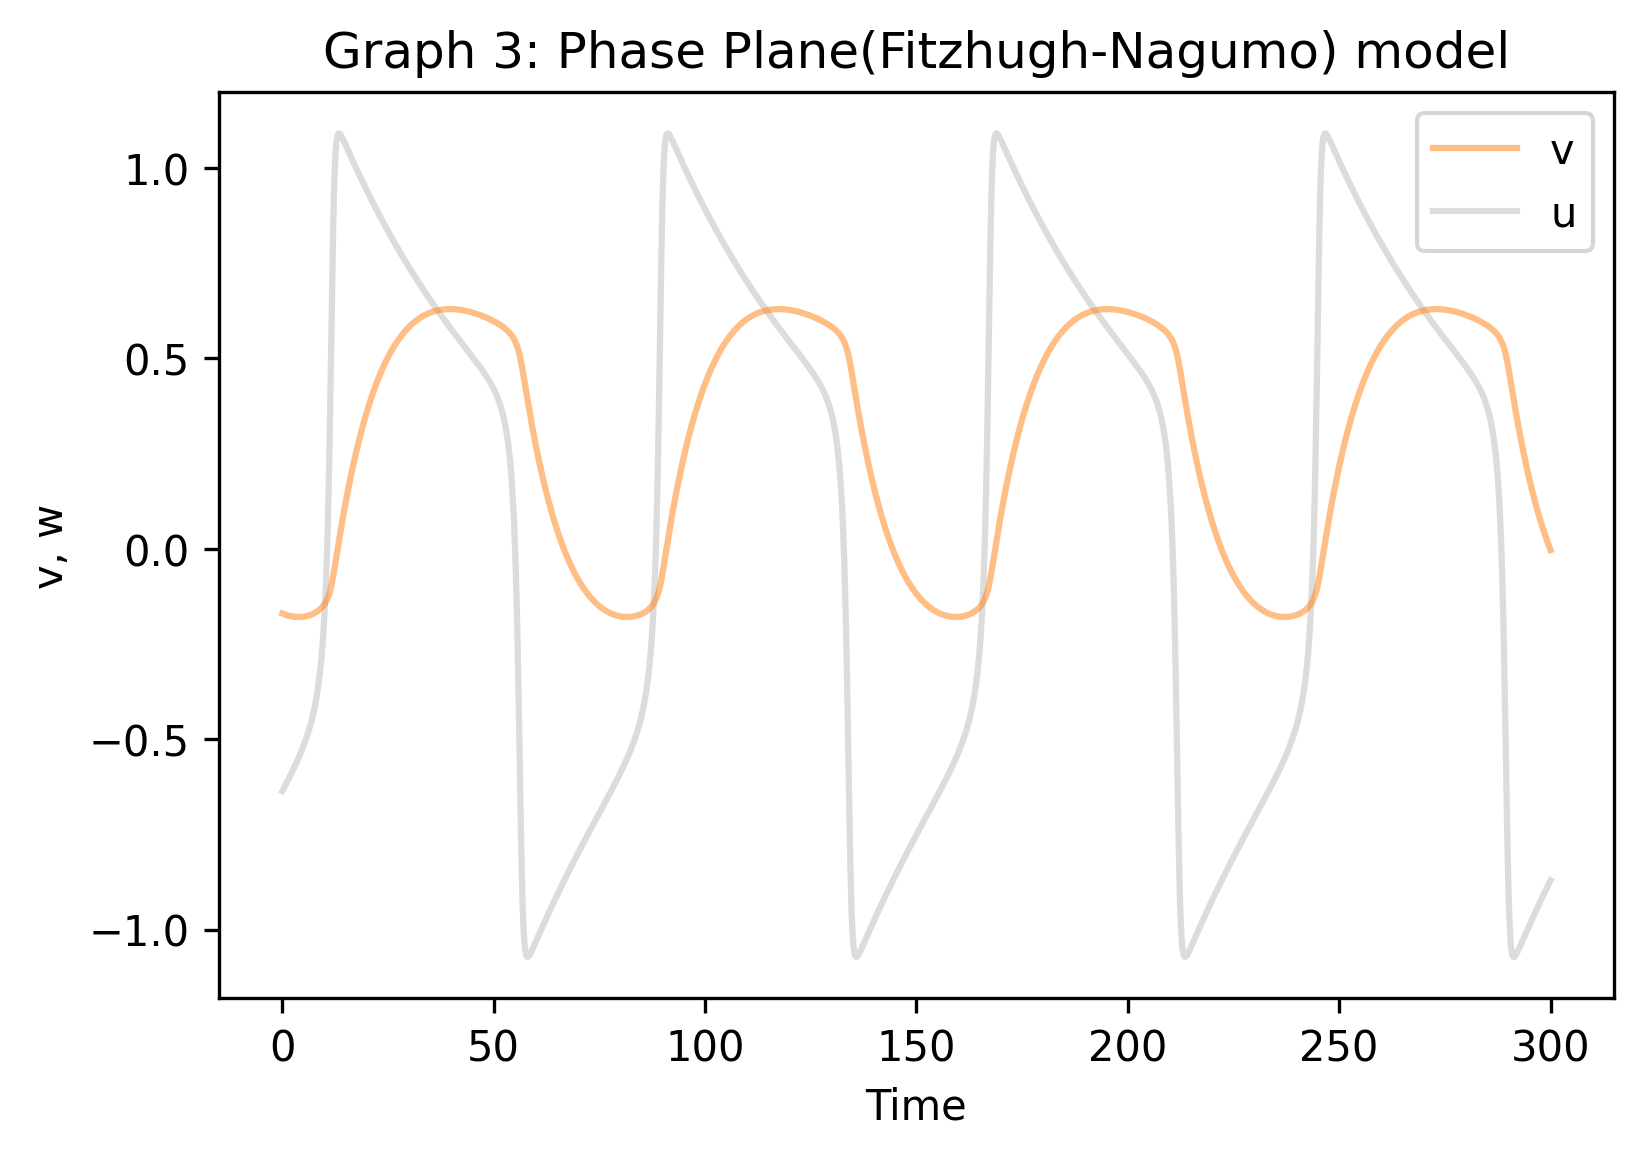

In [15]:
fig, ax = plt.subplots()
ax.set(xlabel='Time', ylabel='v, w',
                title="Graph 3: Phase Plane(Fitzhugh-Nagumo) model")

v = ax.plot(np.linspace(0, finalTime, num=1500),traject[:,0], color='#DCDCDC')
u = ax.plot(np.linspace(0, finalTime, num=1500),traject[:,1], color='C1', alpha=.5)
ax.legend([u[0],v[0]],['v','u']);


We can also plot the phase plane to see how the natural voltage correction occurs

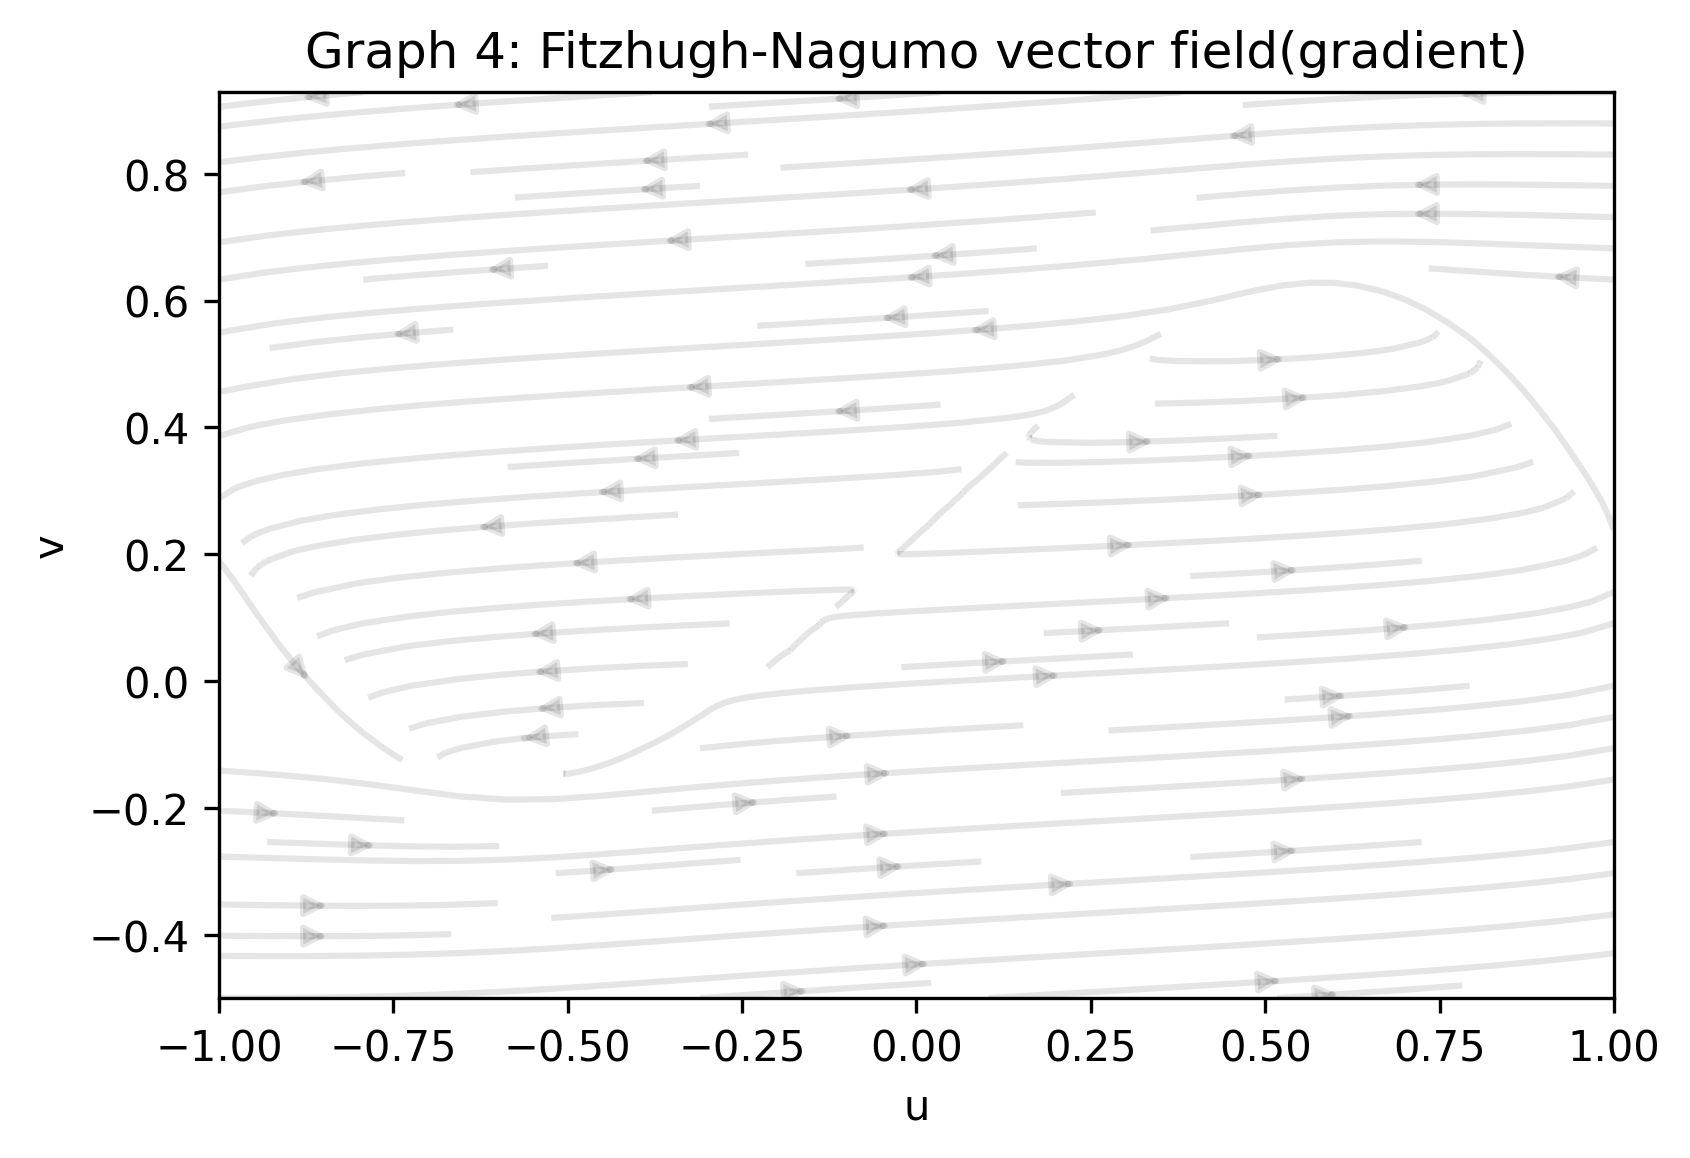

In [19]:
fig,ax = plt.subplots()
def plot_vector_field(ax, param, xrange, yrange, steps=50):
    # Compute the vector field
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dx,dy = PhasePlane([X,Y],0,**param)   
    
    # streamplot is an alternative to quiver 
    # that looks nicer when your vector filed is
    # continuous.
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.1))
    
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

xrange = (-1, 1)
yrange = [(1/sc['b'])*(x-sc['a']) for x in xrange]
plot_vector_field(ax, sc, xrange, yrange)
ax.set(xlabel='u', ylabel='v',
        title="Graph 4: Fitzhugh-Nagumo vector field(gradient)");